# <div align="center">AIML Capstone</div>

### Business Scenario
This problem statement and objective consists of two parts: Part 1 and Part 2


## <div align="center">Part 1</div>
<div align="center">======================================================================================================</div>

### Problem statement 1:<br>
Autonomous vehicles (AV) and intelligent transport systems (ITS) are the future of road transport. Automatic detection of vehicles on the road in real-time helps AV technology and makes ITS more intelligent in terms of vehicle tracking, vehicle counting, and road incident response.

### Objective Part 1:<br>
As the first part of this project, you need to develop an AI model using a deep learning framework that predicts the type of vehicle present in an image as well as localizes the vehicle by rectangular bounding box.


### Project Task:<br>
<div style="margin-left: 20px;">1. Preliminary data inspection and cleaning</div>
<div style="margin-left: 40px;">a. Perform preliminary data inspection, checking for data types, missing values, and duplicates</div>
<div style="margin-left: 40px;">b. Remove any columns that might not be relevant for the analysis</div>
<div style="margin-left: 20px;">2. Exploratory Data Analysis</div>

<div style="margin-left: 20px;">1. Create a parent folder for custom model training and child folders to store data.</div>
<div style="margin-left: 20px;">2. Prepare the dataset for model training and keep the following points in mind while preparing it.</div>
<div style="margin-left: 40px;">• This dataset contains many images, and depending on the compute power of the VM, it might take a very long time to unzip this huge amount of data.</div>
<div style="margin-left: 20px;">3. Create an CNN architecture for object detection of your choice to train an object detection model. Please note that algorithm or architecture selection is a very important aspect of ML model training, and you must pick the one that works the best for your dataset.</div>
<div style="margin-left: 20px;">4. Evaluate the model and check the test results.</div>
<div style="margin-left: 20px;">5. Run inferences on sample images and see if vehicles are detected accurately.</div>
Object detection.

### <span style="color:blue"> Part 1.1: Load various libraries for data manipulation </span>

In [2]:
import shutil
shutil.unpack_archive("Images.zip")
import pandas as pd
import os
import cv2
import numpy as np
import seaborn as sns
import nltk
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder

nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('omw-1.4')

from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\louie\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\louie\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\louie\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\louie\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [2]:
# !pip install opencv-python
# !pip install nltk


### <span style="color:blue"> Part 1.2: Unpacking Data Files</span>

In [3]:
# Load the labels from labels.csv
labels_df = pd.read_csv("labels.csv")

# Rename columns based on assumed structure (update as needed)
labels_df.columns = ['filename', 'class', 'x_min', 'y_min', 'x_max', 'y_max']

# Analyze the distribution of vehicle types in the dataset
vehicle_types = labels_df['class'].value_counts()
print("Vehicle types distribution:\n", vehicle_types)



Vehicle types distribution:
 class
car                      233497
pickup_truck              44282
motorized_vehicle         25845
bus                       10598
articulated_truck          9301
work_van                   8709
pedestrian                 7128
single_unit_truck          5741
non-motorized_vehicle      2350
bicycle                    2260
motorcycle                 1837
Name: count, dtype: int64


### <span style="color:blue"> Part 1.3: Prepare the dataset for model training</span>


In [4]:
# List of available image filenames in the zero-padded format
available_images = set([f.split('.')[0] for f in os.listdir('images')])

# Add a column with zero-padded filenames for filtering
labels_df['padded_filename'] = labels_df['filename'].apply(lambda x: f"{int(x):08d}")

# Filter dataset for entries that have corresponding image files
filtered_labels_df = labels_df[labels_df['padded_filename'].isin(available_images)]

# Drop the helper column for zero-padded filenames
filtered_labels_df = filtered_labels_df.drop(columns=['padded_filename'])

# Final summary of the filtered dataset
print(f"Total entries after filtering: {filtered_labels_df.shape[0]}")


Total entries after filtering: 17966


In [5]:
# Check if the filtered DataFrame has data and inspect a few rows
print(f"Total entries in filtered DataFrame: {len(filtered_labels_df)}")
print(filtered_labels_df.head())

# Confirm the structure and column names of filtered_labels_df to verify data integrity
print("Filtered DataFrame columns:", filtered_labels_df.columns)


Total entries in filtered DataFrame: 17966
   filename              class  x_min  y_min  x_max  y_max
0         0                car    194     78    273    122
1         0                car    155     27    183     35
2         0  articulated_truck     43     25    109     55
3         0                car    106     32    124     45
4         1                bus    205    155    568    314
Filtered DataFrame columns: Index(['filename', 'class', 'x_min', 'y_min', 'x_max', 'y_max'], dtype='object')


In [6]:
# Lists to hold the data
images = []
labels = []
bounding_boxes = []

# Loop through each row in the filtered DataFrame to load images and data
for index, row in filtered_labels_df.iterrows():
    # Construct the file path with zero-padded filename
    padded_filename = f"{int(row['filename']):08d}.jpg"
    img_path = f"images/{padded_filename}"
    
    if os.path.exists(img_path):
        img = cv2.imread(img_path)
        if img is not None:
            # Resize the image to a fixed input size, e.g., 224x224
            img_resized = cv2.resize(img, (224, 224))
            images.append(img_resized)
            
            # Append the label and bounding box
            labels.append(row['class'])
            bounding_boxes.append([row['x_min'], row['y_min'], row['x_max'], row['y_max']])
        else:
            print(f"Could not load image: {img_path}")
    else:
        print(f"File does not exist: {img_path}")

# Convert lists to arrays for compatibility with ML frameworks
images = np.array(images)
labels = np.array(labels)
bounding_boxes = np.array(bounding_boxes)

# Check the final counts
print(f"Total images loaded: {len(images)}")
print(f"Total labels loaded: {len(labels)}")
print(f"Total bounding boxes loaded: {len(bounding_boxes)}")


Total images loaded: 17966
Total labels loaded: 17966
Total bounding boxes loaded: 17966


In [7]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test, bbox_train, bbox_test = train_test_split(
    images, labels, bounding_boxes, test_size=0.2, stratify=labels, random_state=42
)

print(f"Training set size: {len(X_train)}")
print(f"Testing set size: {len(X_test)}")


Training set size: 14372
Testing set size: 3594


### <span style="color:blue"> Part 1.4: Data Augmentation</span>


In [8]:
# Use ImageDataGenerator for data augmentation
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)

# Fit on training data
datagen.fit(X_train)


### <span style="color:blue"> Part 1.5: Create a CNN architecture for object detection</span>


In [9]:
# Defines and compiles a convolutional neural network (CNN) tailored to the objectives of Part 1, which include vehicle detection, classification, and localization in images. By creating a model that outputs both the vehicle type (classification) and bounding box coordinates (localization), it directly supports the project's requirement for an AI model capable of detecting and identifying vehicles with precise spatial awareness.

def create_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    x = layers.Conv2D(32, (3, 3), activation='relu')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(64, (3, 3), activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(128, (3, 3), activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Flatten()(x)
    x = layers.Dropout(0.5)(x)  # Regularization layer to prevent overfitting

    # Output layers
    vehicle_class = layers.Dense(num_classes, activation='softmax', name='vehicle_class')(x)
    bounding_box = layers.Dense(4, activation='linear', name='bounding_box')(x)

    model = keras.Model(inputs=inputs, outputs=[vehicle_class, bounding_box])
    return model

model = create_model((224, 224, 3), num_classes=len(vehicle_types))
model.compile(optimizer='adam', 
              loss={'vehicle_class': 'sparse_categorical_crossentropy', 'bounding_box': 'mse'}, 
              metrics={'vehicle_class': 'accuracy', 'bounding_box': 'mse'})


In [10]:
# Prepares the categorical vehicle type labels and bounding box coordinates for model training by converting them into numerical formats compatible with machine learning models. Encoding vehicle types to integers allows the model to classify vehicles effectively, while converting bounding boxes to float32 ensures precise localization, meeting Part 1's objective to accurately identify and localize different vehicle types in images.

# Encode the vehicle types to integers
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)

# Convert bounding boxes to float type
bbox_train = np.array(bbox_train, dtype=np.float32)
bbox_test = np.array(bbox_test, dtype=np.float32)

# Confirm the data types after conversion
print("y_train dtype:", y_train.dtype)
print("y_test dtype:", y_test.dtype)
print("bbox_train dtype:", bbox_train.dtype)
print("bbox_test dtype:", bbox_test.dtype)



y_train dtype: int64
y_test dtype: int32
bbox_train dtype: float32
bbox_test dtype: float32


In [11]:
# Defines a custom data generator that efficiently loads batches of images, labels, and bounding boxes for model training, enabling the model to classify vehicle types and localize them in images without loading all data at once, which is crucial for handling large datasets. Additionally, it incorporates early stopping to prevent overfitting, ensuring the model maintains optimal accuracy on the validation set by stopping training when no further improvements are detected.

# Define the custom data generator function
def custom_data_generator(images, labels, bounding_boxes, batch_size=32):
    num_samples = len(images)
    while True:
        # Shuffle the indices for each epoch
        indices = np.arange(num_samples)
        np.random.shuffle(indices)
        
        for start in range(0, num_samples, batch_size):
            end = min(start + batch_size, num_samples)
            batch_indices = indices[start:end]
            
            # Prepare batch data
            batch_images = images[batch_indices]
            batch_labels = labels[batch_indices]
            batch_bboxes = bounding_boxes[batch_indices]
            
            # Yield the batch as a tuple with labels and bounding boxes
            yield batch_images, {'vehicle_class': batch_labels, 'bounding_box': batch_bboxes}


# Define batch size
batch_size = 32

# Set up training and validation generators
train_generator = custom_data_generator(X_train, y_train, bbox_train, batch_size)
val_generator = custom_data_generator(X_test, y_test, bbox_test, batch_size)

# Early stopping to prevent overfitting
# early_stopping = EarlyStopping(monitor='val_vehicle_class_accuracy', patience=5, restore_best_weights=True)

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(
    monitor='val_vehicle_class_accuracy',
    patience=5,
    restore_best_weights=True,
    mode='max'  # Specify to maximize accuracy
)


# Train the model using the custom generator
history = model.fit(
    train_generator,
    validation_data=val_generator,
    steps_per_epoch=len(X_train) // batch_size,
    validation_steps=len(X_test) // batch_size,
    epochs=50,
    callbacks=[early_stopping]
)



Epoch 1/50
449/449 ━━━━━━━━━━━━━━━━━━━━ 261s 574ms/step - bounding_box_mse: 23527.4453 - loss: 23538.8906 - vehicle_class_accuracy: 0.5111 - val_bounding_box_mse: 18492.1289 - val_loss: 18506.0273 - val_vehicle_class_accuracy: 0.6046
Epoch 2/50
449/449 ━━━━━━━━━━━━━━━━━━━━ 255s 568ms/step - bounding_box_mse: 17379.8164 - loss: 17392.3145 - vehicle_class_accuracy: 0.5453 - val_bounding_box_mse: 24450.1074 - val_loss: 24463.9102 - val_vehicle_class_accuracy: 0.3563
Epoch 3/50
449/449 ━━━━━━━━━━━━━━━━━━━━ 254s 567ms/step - bounding_box_mse: 17002.5625 - loss: 17015.7285 - vehicle_class_accuracy: 0.5490 - val_bounding_box_mse: 17944.3691 - val_loss: 17956.3711 - val_vehicle_class_accuracy: 0.4851
Epoch 4/50
449/449 ━━━━━━━━━━━━━━━━━━━━ 254s 566ms/step - bounding_box_mse: 16755.3008 - loss: 16767.6680 - vehicle_class_accuracy: 0.5708 - val_bounding_box_mse: 18005.8320 - val_loss: 18018.8418 - val_vehicle_class_accuracy: 0.6272
Epoch 5/50
449/449 ━━━━━━━━━━━━━━━━━━━━ 254s 567ms/step - boundi

### <span style="color:blue"> Part 1.6: Evaluate the model and check the test results</span>

In [12]:
# Evaluates the model's performance on the test set, giving an accuracy and loss metric for both vehicle classification and bounding box predictions, which is essential to understand how well the model generalizes to unseen data. The classification report provides a detailed breakdown of the model's accuracy, precision, recall, and F1-score across different vehicle classes, offering insights into the specific strengths and weaknesses in predicting each class, which aligns with Part 1's goal of accurately detecting and localizing vehicles in real-time.

# Evaluate performance with test set
test_results = model.evaluate(X_test, {'vehicle_class': y_test, 'bounding_box': bbox_test}, verbose=1)

# Detailed classification report for vehicle type predictions
pred_class = np.argmax(model.predict(X_test)[0], axis=1)
print("Classification Report:\n", classification_report(y_test, pred_class))


113/113 ━━━━━━━━━━━━━━━━━━━━ 12s 103ms/step - bounding_box_mse: 17517.9883 - loss: 17534.6875 - vehicle_class_accuracy: 0.6283
113/113 ━━━━━━━━━━━━━━━━━━━━ 12s 103ms/step
Classification Report:
               precision    recall  f1-score   support

           0       0.07      0.02      0.03        92
           1       0.36      0.15      0.22        26
           2       0.36      0.18      0.24       112
           3       0.70      0.90      0.79      2416
           4       0.00      0.00      0.00        19
           5       0.10      0.03      0.04       259
           6       0.00      0.00      0.00        22
           7       0.30      0.28      0.29        68
           8       0.35      0.15      0.22       427
           9       0.00      0.00      0.00        61
          10       0.10      0.07      0.08        92

    accuracy                           0.64      3594
   macro avg       0.21      0.16      0.17      3594
weighted avg       0.54      0.64      0.58    

### <span style="color:blue"> Part 1.7: Run inferences on sample images</span>

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


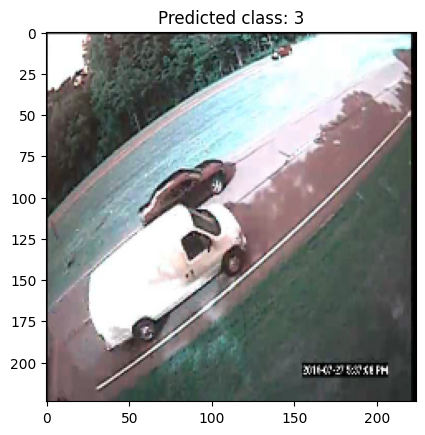

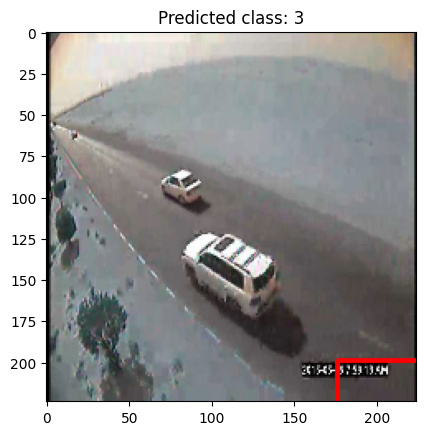

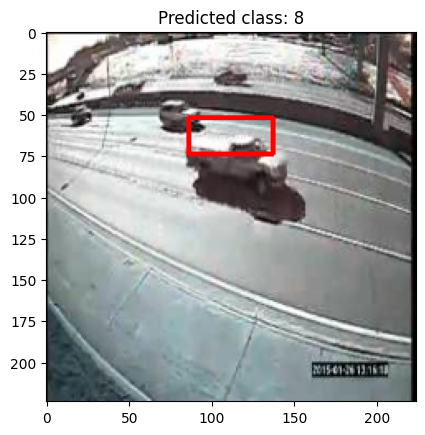

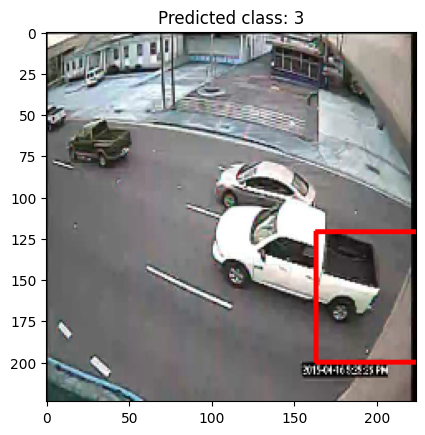

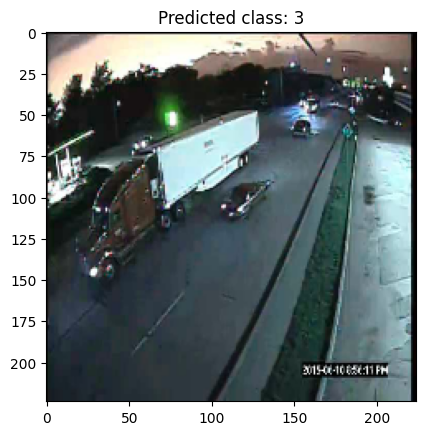

In [13]:
# Visual validattion of the model's performance in Part 1 by displaying predicted bounding boxes and class labels on a sample set of test images. This step helps assess if the model accurately identifies and localizes vehicles in real-world images, which is key to determining the reliability of the object detection system for autonomous vehicle technology
# Visualize predictions on a few samples
sample_images = X_test[:5]
predicted_bboxes = model.predict(sample_images)[1]

for i, img in enumerate(sample_images):
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title(f"Predicted class: {pred_class[i]}")
    
    # Draw bounding box
    bbox = predicted_bboxes[i]
    cv2.rectangle(img, (int(bbox[0]), int(bbox[1])), (int(bbox[2]), int(bbox[3])), (255, 0, 0), 2)
    plt.imshow(img)
    plt.show()


## <div align="center">Part 2</div>
<div align="center">======================================================================================================</div>

### Problem statement 2:<br>
Tesla, Inc. is an American multinational automotive and artificial intelligence company. In October 2020, Tesla started a full self-driving capability beta program in the United States. Tesla has over 100k people in this program.

### Objective Part 2:<br>
As the second part of this project, you need to analyze the usage of autopilot and its effect on road safety.

### Project Task:<br>
<div style="margin-left: 20px;">1. Preliminary data inspection and cleaning</div>
<div style="margin-left: 40px;">a. Perform preliminary data inspection, checking for data types, missing values, and duplicates</div>
<div style="margin-left: 40px;">b. Remove any columns that might not be relevant for the analysis</div>
<div style="margin-left: 20px;">2. Exploratory Data Analysis</div>
<div style="margin-left: 40px;">a. Perform an in-depth exploratory data analysis on the number of events by date, per year, and per day for each state and country</div>
<div style="margin-left: 40px;">b. Analyze the different aspects of the death events. For example:</div>
<div style="margin-left: 60px;">• What is the number of victims (deaths) in each accident?</div>
<div style="margin-left: 60px;">• How many times did tesla drivers die?</div>
<div style="margin-left: 60px;">• What is the proportion of events in which one or more occupants died?</div>
<div style="margin-left: 60px;">• What is the distribution of events in which the vehicle hit a cyclist or a pedestrian?</div>
<div style="margin-left: 60px;">• How many times did the accident involve the death of an occupant or driver of a Tesla along with a cyclist or pedestrian6</div>
<div style="margin-left: 60px;">• What is the frequency of Tesla colliding with other vehicles?</div>
<div style="margin-left: 40px;">c. Study the event distribution across models</div>
<div style="margin-left: 40px;">d. Check the distribution of verified Tesla autopilot deaths</div>

### <span style="color:blue"> Part 2.1: Data Preparation, Data Inspection, and Data Cleaning.</span>
Perform preliminary data inspection, checking for data types, missing values, and duplicates.

Remove any columns that might not be relevant for the analysis

In [8]:
# Loading of Data and inital inspection of the table. 
data = pd.read_csv("Tesla - Deaths.csv")
data.head()

,Case #,Year,Date,Country,State,Description,Deaths,Tesla driver,Tesla occupant,Other vehicle,...,Verified Tesla Autopilot Deaths,Verified Tesla Autopilot Deaths + All Deaths Reported to NHTSA SGO,Unnamed: 16,Unnamed: 17,Source,Note,Deceased 1,Deceased 2,Deceased 3,Deceased 4
0,294.0,2022.0,1/17/2023,USA,CA,Tesla crashes into back of semi,1.0,1,-,-,...,-,-,https://web.archive.org/web/20221222203930/ht...,https://web.archive.org/web/20221222203930/ht...,https://web.archive.org/web/20230118162813/ht...,NaN,NaN,NaN,NaN,NaN
1,293.0,2022.0,1/7/2023,Canada,-,Tesla crashes,1.0,1,-,-,...,-,-,https://web.archive.org/web/20221222203930/ht...,https://web.archive.org/web/20221222203930/ht...,https://web.archive.org/web/20230109041434/ht...,NaN,Taren Singh Lal,NaN,NaN,NaN
2,292.0,2022.0,1/7/2023,USA,WA,"Tesla hits pole, catches on fire",1.0,-,1,-,...,-,-,https://web.archive.org/web/20221222203930/ht...,https://web.archive.org/web/20221222203930/ht...,https://web.archive.org/web/20230107232745/ht...,NaN,NaN,NaN,NaN,NaN
3,291.0,2022.0,12/22/2022,USA,GA,Tesla crashes and burns,1.0,1,-,-,...,-,-,https://web.archive.org/web/20221222203930/ht...,https://web.archive.org/web/20221222203930/ht...,https://web.archive.org/web/20221222203930/ht...,NaN,NaN,NaN,NaN,NaN
4,290.0,2022.0,12/19/2022,Canada,-,Tesla crashes into storefront,1.0,-,-,-,...,-,-,https://web.archive.org/web/20221223203725/ht...,https://web.archive.org/web/20221223203725/ht...,https://web.archive.org/web/20221223203725/ht...,NaN,NaN,NaN,NaN,NaN


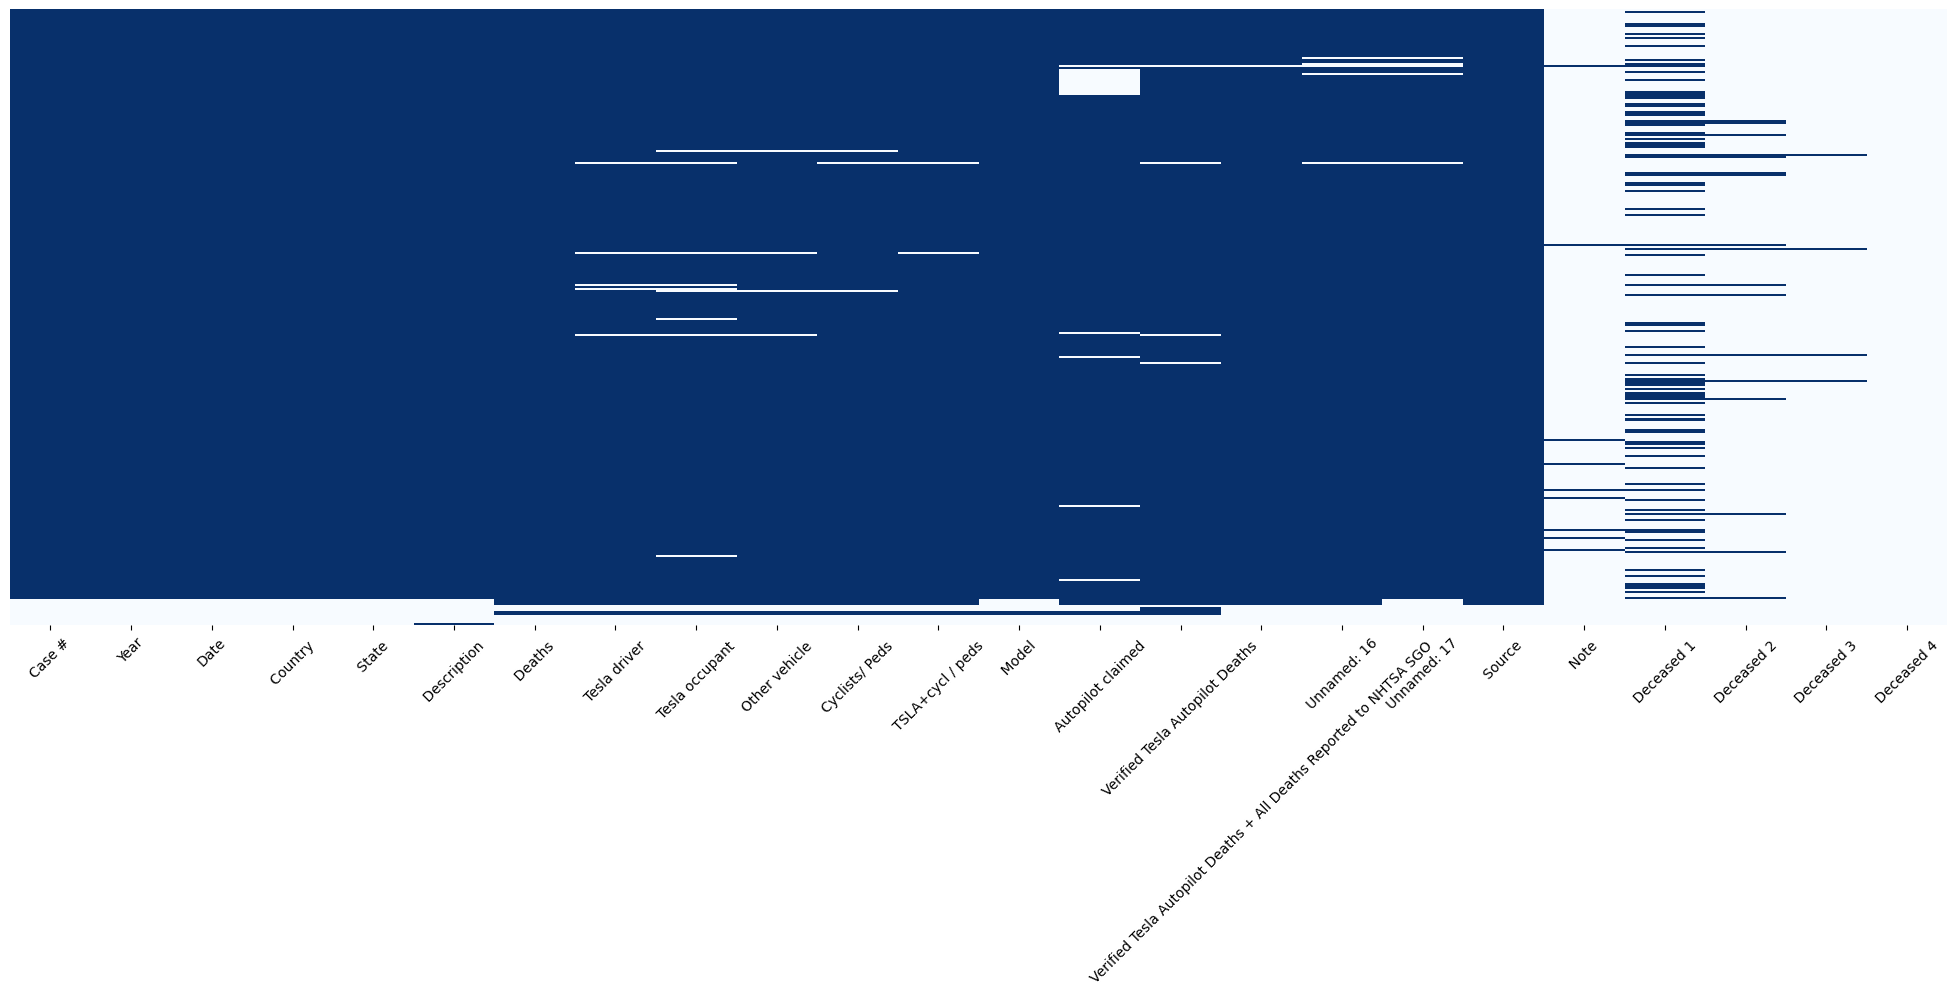

In [9]:
# Identifying the missing values across columns, which is a crucial step in ensuring data completeness and reliability before performing any further analysis. Visualizing missing data with a heatmap allows you to quickly detect patterns in data gaps, helping to inform decisions about data cleaning and preprocessing, which are critical for accurate analysis of incident trends and safety outcomes in Tesla's autopilot usage.

# Perform initial data inspection checking for data types, missing values, duplicates.
missing_values = data.isna()
plt.figure(figsize = (25,8))
sns.heatmap(missing_values, cmap = "Blues_r", cbar=False)
plt.tick_params( left = False,labelleft = False)
plt.xticks(rotation = 45)
plt.show()

In [10]:
# Data Cleaning for columns which maynot be relevant.
data.isna().sum()

Case #                                                                   13
Year                                                                     13
Date                                                                     13
 Country                                                                 13
 State                                                                   13
 Description                                                             12
 Deaths                                                                   8
 Tesla driver                                                            13
 Tesla occupant                                                          17
 Other vehicle                                                           12
 Cyclists/ Peds                                                          11
 TSLA+cycl / peds                                                        10
 Model                                                                   11
 Autopilot c

In [11]:
# Identify the data columns  
data.columns

Index(['Case #', 'Year', 'Date', ' Country ', ' State ', ' Description ',
       ' Deaths ', ' Tesla driver ', ' Tesla occupant ', ' Other vehicle ',
       ' Cyclists/ Peds ', ' TSLA+cycl / peds ', ' Model ',
       ' Autopilot claimed ', ' Verified Tesla Autopilot Deaths ',
       ' Verified Tesla Autopilot Deaths + All Deaths Reported to NHTSA SGO ',
       'Unnamed: 16', 'Unnamed: 17', ' Source ', ' Note ', ' Deceased 1 ',
       ' Deceased 2 ', ' Deceased 3 ', ' Deceased 4 '],
      dtype='object')

In [12]:
# Ensuring data relevance and accuracy by removing unnecessary columns.
drop_columns = ['Case #','Year', 'Unnamed: 16', 'Unnamed: 17', ' Source ', ' Note ', ' Deceased 1 ',
       ' Deceased 2 ', ' Deceased 3 ', ' Deceased 4 ']
data.drop(columns = drop_columns, inplace = True)

In [13]:
# Understanding the distribution of reported deaths associated with Tesla's autopilot.
data[' Verified Tesla Autopilot Deaths + All Deaths Reported to NHTSA SGO '].value_counts(dropna = False)


 Verified Tesla Autopilot Deaths + All Deaths Reported to NHTSA SGO 
 -       269
  1       21
NaN       11
  2        3
  3        1
  24       1
  27       1
Name: count, dtype: int64

In [14]:
# Removes the column "Verified Tesla Autopilot Deaths + All Deaths Reported to NHTSA SGO" from the dataset, which is likely unnecessary for the specific analysis goals in Part 2. Since the objective includes analyzing Tesla autopilot usage and incident specifics rather than general NHTSA-reported deaths, excluding this column refines the dataset, reducing potential noise and enhancing the focus on autopilot-related insights.

data.drop(columns = ' Verified Tesla Autopilot Deaths + All Deaths Reported to NHTSA SGO ', inplace = True)
data

,Date,Country,State,Description,Deaths,Tesla driver,Tesla occupant,Other vehicle,Cyclists/ Peds,TSLA+cycl / peds,Model,Autopilot claimed,Verified Tesla Autopilot Deaths
0,1/17/2023,USA,CA,Tesla crashes into back of semi,1.0,1,-,-,-,1,-,-,-
1,1/7/2023,Canada,-,Tesla crashes,1.0,1,-,-,-,1,-,-,-
2,1/7/2023,USA,WA,"Tesla hits pole, catches on fire",1.0,-,1,-,-,1,-,-,-
3,12/22/2022,USA,GA,Tesla crashes and burns,1.0,1,-,-,-,1,-,-,-
4,12/19/2022,Canada,-,Tesla crashes into storefront,1.0,-,-,-,1,1,-,-,-
...,...,...,...,...,...,...,...,...,...,...,...,...,...
302,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
303,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
304,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
305,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [15]:
# Looking for missing data
data.head()
data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307 entries, 0 to 306
Data columns (total 13 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Date                               294 non-null    object 
 1    Country                           294 non-null    object 
 2    State                             294 non-null    object 
 3    Description                       295 non-null    object 
 4    Deaths                            299 non-null    float64
 5    Tesla driver                      294 non-null    object 
 6    Tesla occupant                    290 non-null    object 
 7    Other vehicle                     295 non-null    object 
 8    Cyclists/ Peds                    296 non-null    object 
 9    TSLA+cycl / peds                  297 non-null    object 
 10   Model                             296 non-null    object 
 11   Autopilot claimed                 281 non-null    object 

In [16]:
data.columns

Index(['Date', ' Country ', ' State ', ' Description ', ' Deaths ',
       ' Tesla driver ', ' Tesla occupant ', ' Other vehicle ',
       ' Cyclists/ Peds ', ' TSLA+cycl / peds ', ' Model ',
       ' Autopilot claimed ', ' Verified Tesla Autopilot Deaths '],
      dtype='object')

In [17]:
# Preparing data columns relevant to incident analysis by ensuring that missing values are replaced and that data consistency is maintained across categories. 
cols = data.columns[5:]
for col in cols:
  if col != ' Model ':
    print(col)
    data[col] = data[col].fillna("-")
    data[col] = data[col].str.strip()
    data[col] = data[col].replace("-", "0")
    data[col] = data[col].astype(int)
    print(data[col].unique())

 Tesla driver 
[   1    0   28   89  117    6 2014]
 Tesla occupant 
[   0    1    3    2    7   41   48    5 2015]
 Other vehicle 
[   0    1    2    3    4   29  101  130   16 2016]
 Cyclists/ Peds 
[   0    1    2   20   26   46   11 2017]
 TSLA+cycl / peds 
[   1    0    2    3    4   61  149  210   21 2018]
 Autopilot claimed 
[   0    1    2    8   30   38   47 2020]
 Verified Tesla Autopilot Deaths 
[   0    1    2    3   16   19  118 2022   75 2021]


In [18]:
data.isna().sum()

Date                                 13
 Country                             13
 State                               13
 Description                         12
 Deaths                               8
 Tesla driver                         0
 Tesla occupant                       0
 Other vehicle                        0
 Cyclists/ Peds                       0
 TSLA+cycl / peds                     0
 Model                               11
 Autopilot claimed                    0
 Verified Tesla Autopilot Deaths      0
dtype: int64

In [19]:
data.dropna(inplace = True)

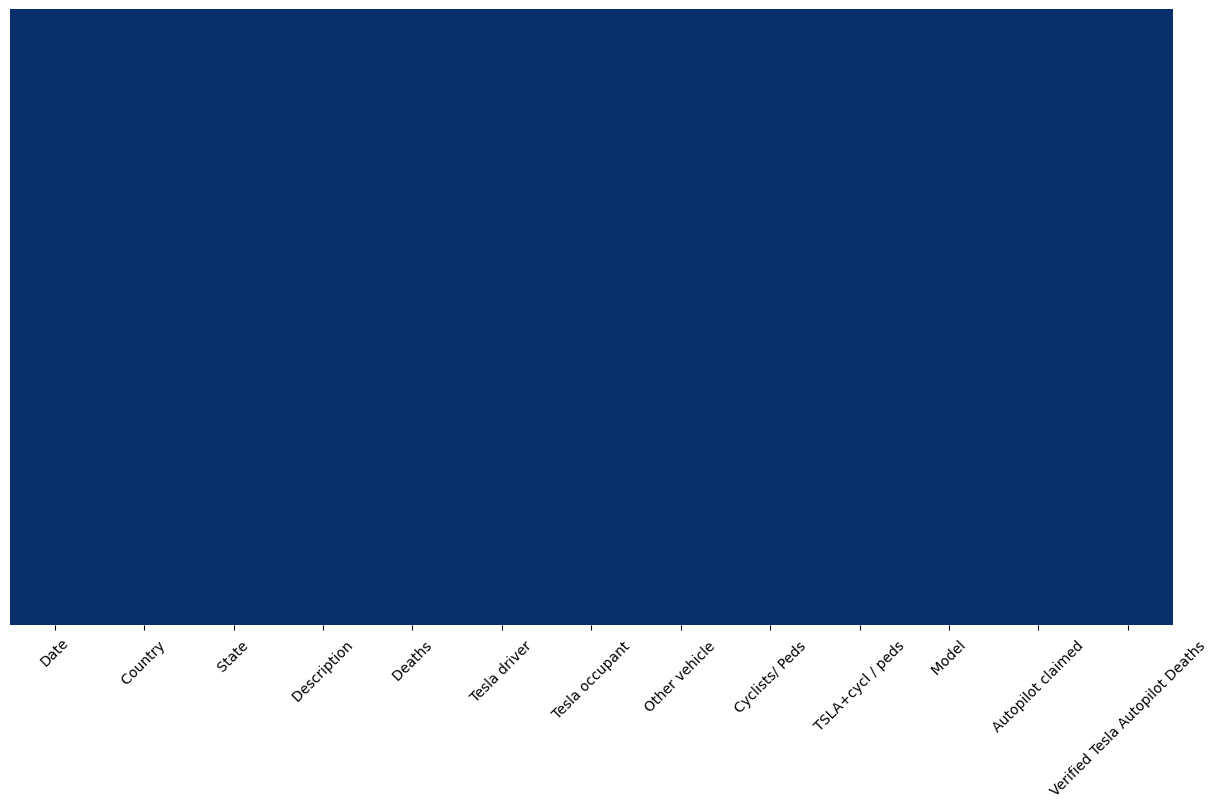

In [20]:
# Visually identify missing values in the dataset, helping you quickly pinpoint areas that may require cleaning or imputation, a critical first step for ensuring data quality.
missing_values = data.isna()
plt.figure(figsize = (15,8))
sns.heatmap(missing_values, cmap = "Blues_r", cbar=False)
plt.tick_params( left = False,labelleft = False)
plt.xticks(rotation = 45)
plt.show()

In [21]:
# Standardizing column names by removing spaces and replacing special characters (like "+" or "/") with underscores.

data.columns = data.columns.str.replace(" ", "", regex = True).str.replace("[+/]","_",regex = True)
data.columns

Index(['Date', 'Country', 'State', 'Description', 'Deaths', 'Tesladriver',
       'Teslaoccupant', 'Othervehicle', 'Cyclists_Peds', 'TSLA_cycl_peds',
       'Model', 'Autopilotclaimed', 'VerifiedTeslaAutopilotDeaths'],
      dtype='object')

In [23]:
# Standardizes the column names to be more readable and consistent, aligning them with conventions that make subsequent analysis more manageable and clear

data.rename(columns = {"Autopilotclaimed":"Claimed", "VerifiedTeslaAutopilotDeaths":"VTAD",
                       "Teslaoccupant" : "Tesla_Occupant", "Othervehicle":'Other_Vehicle',
                       "Tesladriver": "Tesla_Driver"}, inplace = True)
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 294 entries, 0 to 293
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Date            294 non-null    object 
 1   Country         294 non-null    object 
 2   State           294 non-null    object 
 3   Description     294 non-null    object 
 4   Deaths          294 non-null    float64
 5   Tesla_Driver    294 non-null    int32  
 6   Tesla_Occupant  294 non-null    int32  
 7   Other_Vehicle   294 non-null    int32  
 8   Cyclists_Peds   294 non-null    int32  
 9   TSLA_cycl_peds  294 non-null    int32  
 10  Model           294 non-null    object 
 11  Claimed         294 non-null    int32  
 12  VTAD            294 non-null    int32  
dtypes: float64(1), int32(7), object(5)
memory usage: 24.1+ KB


In [24]:
data

,Date,Country,State,Description,Deaths,Tesla_Driver,Tesla_Occupant,Other_Vehicle,Cyclists_Peds,TSLA_cycl_peds,Model,Claimed,VTAD
0,1/17/2023,USA,CA,Tesla crashes into back of semi,1.0,1,0,0,0,1,-,0,0
1,1/7/2023,Canada,-,Tesla crashes,1.0,1,0,0,0,1,-,0,0
2,1/7/2023,USA,WA,"Tesla hits pole, catches on fire",1.0,0,1,0,0,1,-,0,0
3,12/22/2022,USA,GA,Tesla crashes and burns,1.0,1,0,0,0,1,-,0,0
4,12/19/2022,Canada,-,Tesla crashes into storefront,1.0,0,0,0,1,1,-,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
289,7/14/2014,USA,CA,Tesla kills motorcyclist,1.0,0,0,1,0,0,-,0,0
290,7/4/2014,USA,CA,Thief crashes stolen Tesla,1.0,1,0,0,0,1,-,0,0
291,7/4/2014,USA,CA,Tesla rear ends stopped car,3.0,0,0,3,0,0,-,0,0
292,11/2/2013,USA,CA,Tesla kills cyclist,1.0,0,0,0,1,1,-,0,0


### <span style="color:blue"> Part 2.2: Exploratory Data Analysis (EDA)</span>
Perform an in-depth exploratory data analysis on the number of events by date, per year, and per day for each state and country

In [25]:
# Split the date into year month and day
data.Date = pd.to_datetime(data.Date)

data.loc[:,"event_year"] = data.Date.dt.year
data.loc[:,"event_month"] = data.Date.dt.month
data.loc[:,"event_day"] = data.Date.dt.day

In [26]:
# Year wise info
# remove year 2023 as too little info available
data = data[data.event_year!= 2023]

vc = data.event_year.value_counts()
vc = vc.sort_index()
vc


event_year
2013     2
2014     4
2015     5
2016    15
2017    11
2018    18
2019    46
2020    39
2021    58
2022    93
Name: count, dtype: int64

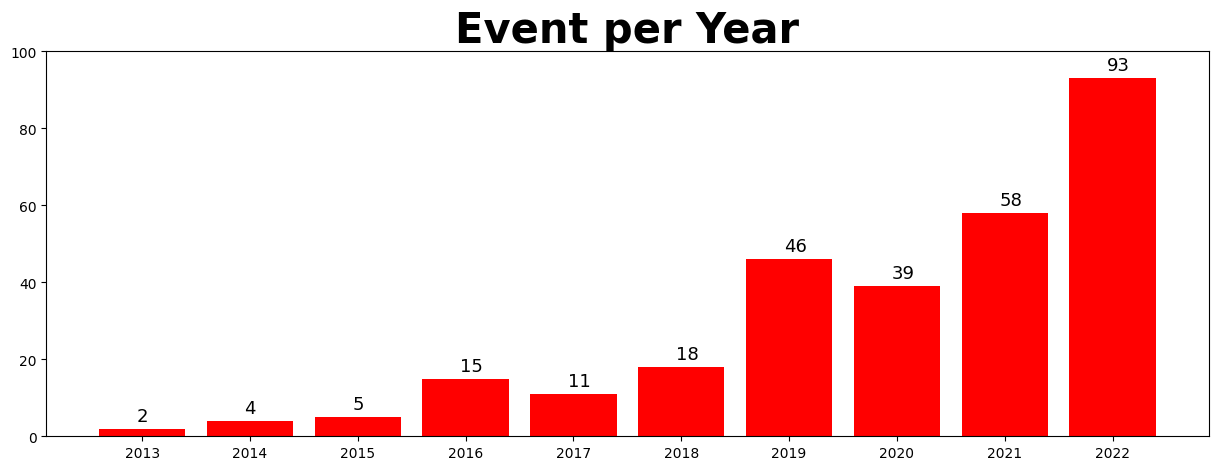

In [27]:
# Create a visual summary of the frequency of incidents by year, helping identify trends in the occurrence of events over time. By using annotations on each bar, it provides clear insight into yearly incident counts, which is crucial for understanding temporal patterns that could indicate high-risk periods or growth trends in autopilot-related incidents.

plt.figure(figsize = (15,5))
plt.bar(height = vc.values, x = vc.index, color = "red")
plt.xticks(vc.index, vc.index)
for i in vc.index:
  plt.annotate(vc[i], xy = (i-0.05, vc[i]+2), size = 13)
plt.ylim(0,100)
plt.title("Event per Year", size = 30, weight = "heavy")
plt.show()

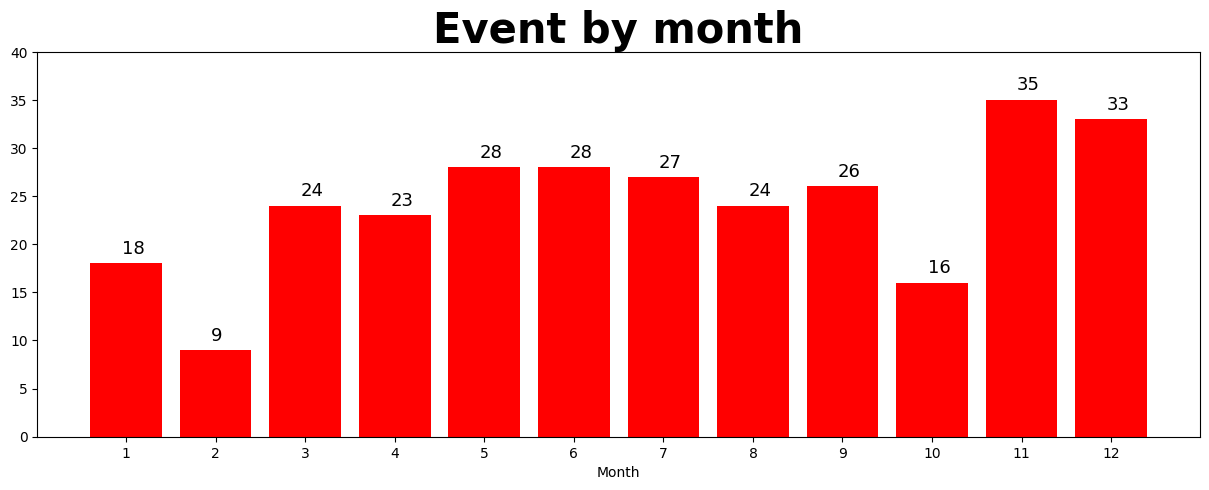

In [28]:
# Visualize the distribution of incidents by month, a crucial step in analyzing temporal patterns as outlined in Part 2's objectives. By identifying peak months for events, it helps to reveal potential seasonal or environmental factors influencing the frequency of Tesla-related incidents, which is valuable for safety analysis and improving autonomous systems.

vc = data.event_month.value_counts()
vc = vc.sort_index()
plt.figure(figsize = (15,5))
plt.bar(height = vc.values, x = vc.index, color = "red")
plt.xticks(vc.index, vc.index)
for i in vc.index:
  plt.annotate(vc[i], xy = (i-0.05, vc[i]+1), size = 13)
plt.ylim(0, 5 * round(vc.max()/5) +5)
plt.xlabel("Month")
plt.title("Event by month", size = 30, weight = "heavy")
plt.show()

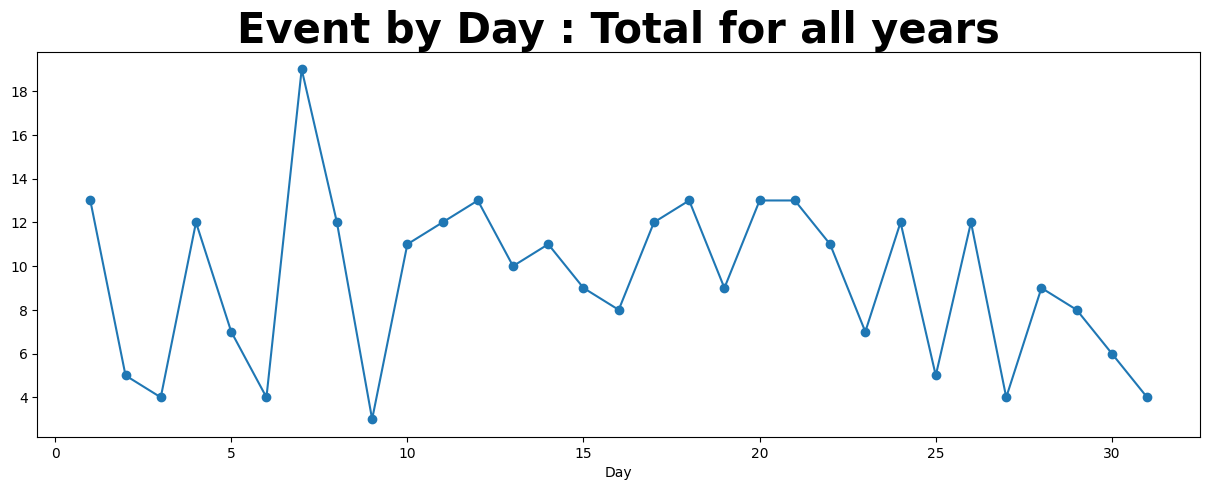

In [29]:
# Visualize the temporal distribution of incidents, specifically examining patterns across days and months, which aligns with the objective of understanding event frequency over time as outlined in Part 2. By plotting daily and monthly event trends, this code helps reveal high-risk periods, enabling insights into when Tesla autopilot-related incidents are more likely to occur and informing targeted safety improvements.

vc = data.event_day.value_counts()
vc = vc.sort_index()
plt.figure(figsize = (15,5))
plt.plot( vc.index, vc.values)
plt.scatter( vc.index, vc.values)
plt.xlabel("Day")
plt.title("Event by Day : Total for all years", size = 30, weight = "heavy")
plt.show()

C:\Users\louie\AppData\Local\Temp\ipykernel_49672\260446144.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.annotate(vc[i], xy = (i-0.1, vc[i]+2), size = 10)


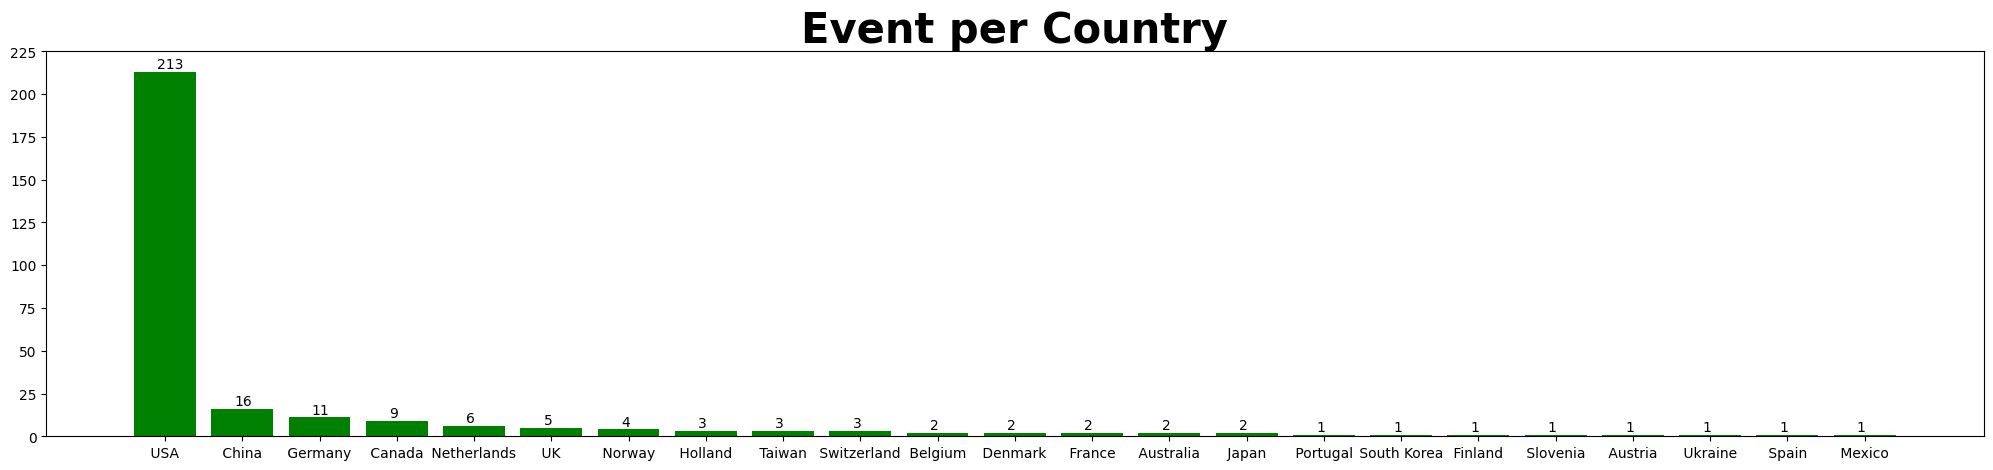

In [30]:
# This plot generated shows the number of events in each country, with each bar labeled with its count value.
vc = data.Country.value_counts()
plt.figure(figsize = (25,5))
plt.bar(height = vc.values, x = vc.index, color = "green")
plt.xticks(vc.index, vc.index)
for i in range(len(vc.index)):
  plt.annotate(vc[i], xy = (i-0.1, vc[i]+2), size = 10)
plt.title("Event per Country", size = 30, weight = "heavy")
plt.ylim(0, 25 * round(vc.max()/25))
plt.show()

In [31]:
data['State'] = data['State'].str.strip()


C:\Users\louie\AppData\Local\Temp\ipykernel_49672\3879890861.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['State'] = data['State'].str.strip()


C:\Users\louie\AppData\Local\Temp\ipykernel_49672\582903224.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.annotate(vc[i], xy = (i-0.1, vc[i]+2), size = 10)


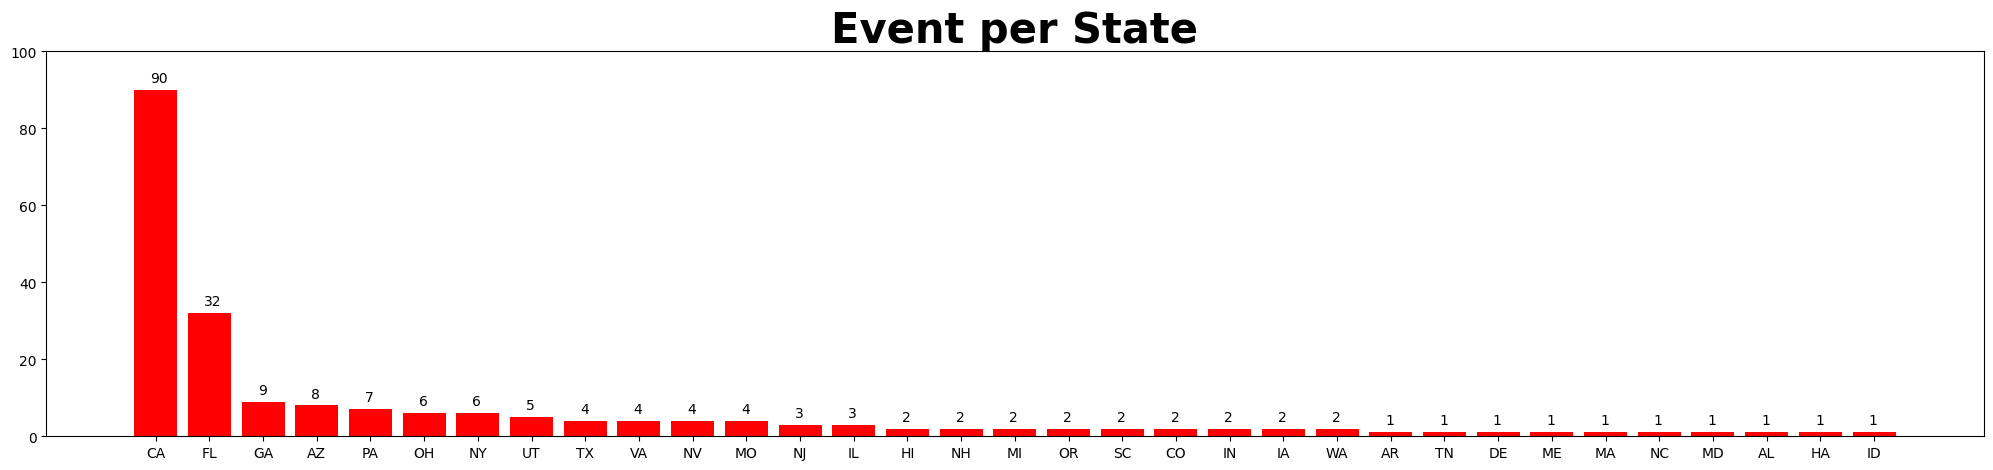

In [32]:
# Visualize the distribution of safety events across different states, which aligns with Part 2's objective to analyze geographic patterns in Tesla autopilot incidents.

vc = data.State.value_counts()
vc = vc[vc.index != "-"]
plt.figure(figsize = (25,5))
plt.bar(height = vc.values, x = vc.index, color = "red")
plt.xticks(vc.index, vc.index)
for i in range(len(vc.index)):
  plt.annotate(vc[i], xy = (i-0.1, vc[i]+2), size = 10)
plt.title("Event per State", size = 30,  weight = "heavy")
plt.ylim(0, 25 * round(vc.max()/25))
plt.show()


### <span style="color:blue"> Part 2.3: Incident Analysis by Vehicle Model.</span>
### Analyse the different aspects of the death events. For example 
<div style="margin-left: 40px;">1. Compare the number of victims(deaths) in each accident.</div>
<div style="margin-left: 40px;">2. In how many events the tesla driver died.</div>
<div style="margin-left: 40px;">3. What is the proportion of events in which 1 or more occupants died ?</div>
<div style="margin-left: 40px;">4. What is the distribution of events in which the vehicle hit a cyclist or a pedestrian ?</div>
<div style="margin-left: 40px;">5. How many times did the accident involve the death of an occupant or driver of a Tesla along with a cyclist or pedestrian ?</div>
<div style="margin-left: 40px;">6. What is the percentage of times tesla hit some other vehicle.</div>



In [33]:
data.columns

Index(['Date', 'Country', 'State', 'Description', 'Deaths', 'Tesla_Driver',
       'Tesla_Occupant', 'Other_Vehicle', 'Cyclists_Peds', 'TSLA_cycl_peds',
       'Model', 'Claimed', 'VTAD', 'event_year', 'event_month', 'event_day'],
      dtype='object')

In [34]:
col_list = ['Deaths', 'Tesla_Driver','Tesla_Occupant', 'Other_Vehicle', 'Cyclists_Peds', 'TSLA_cycl_peds']
colr = ['salmon', 'mediumaquamarine', 'mediumpurple', 'goldenrod', 'silver', 'saddlebrown']

### Analysis of different aspects of the death events.

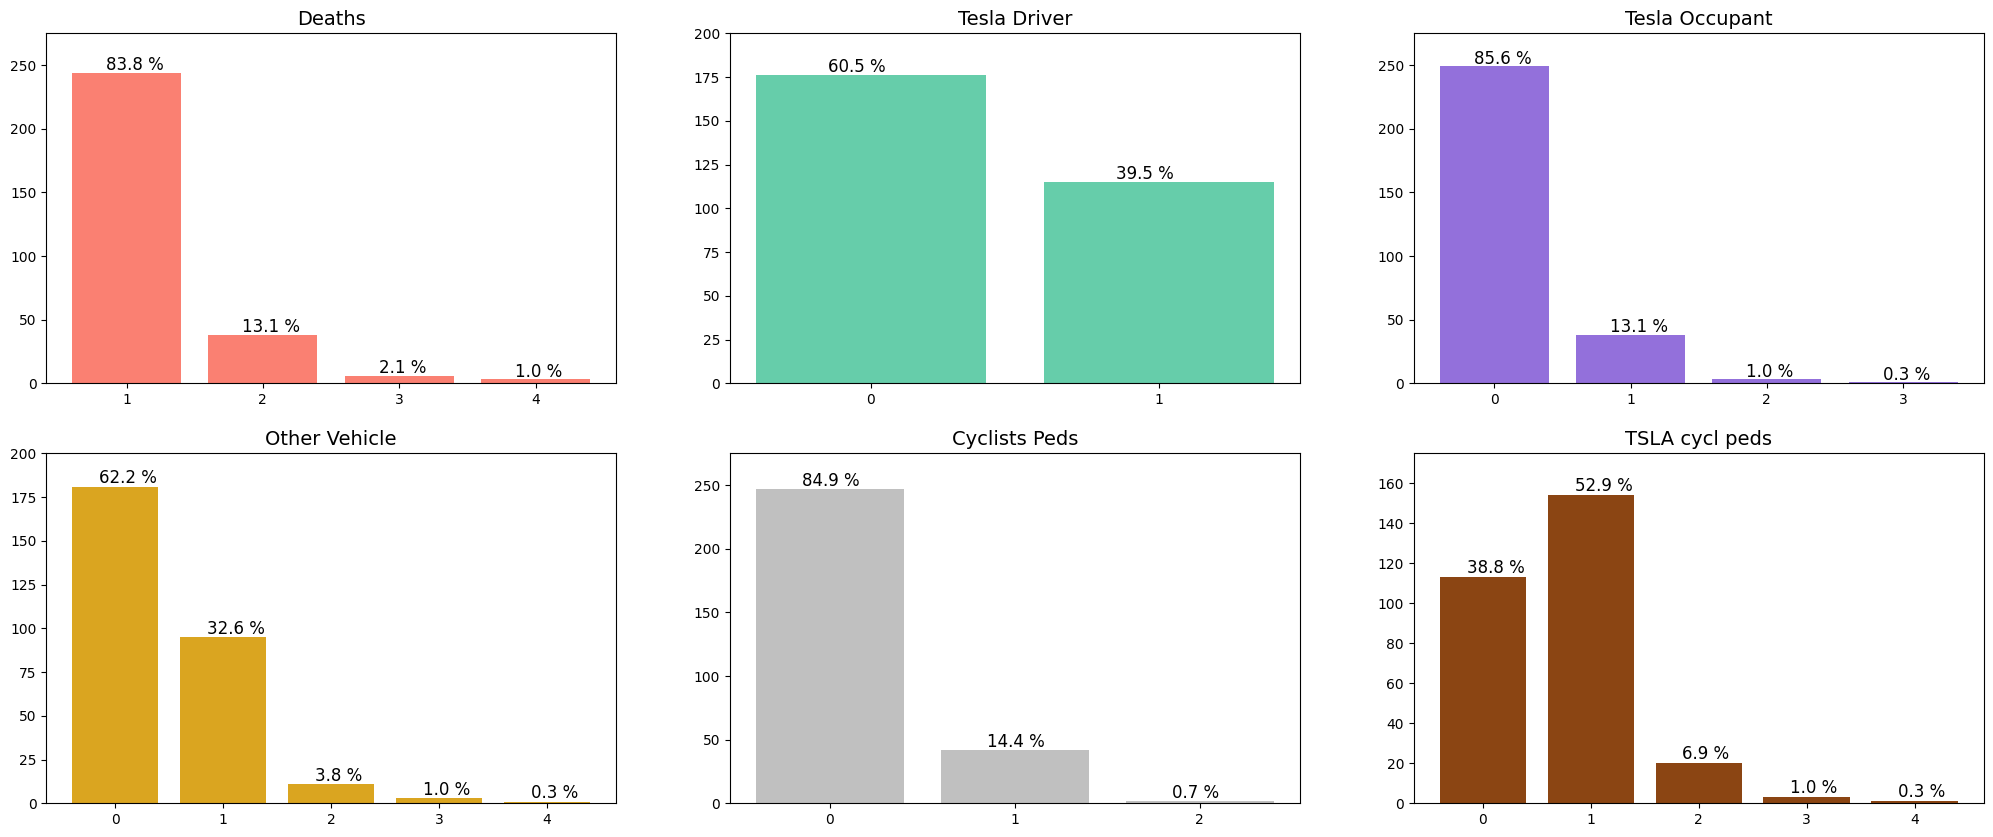

In [46]:
# Visualizing the distribution of events across multiple categorical columns in the dataset, allowing a detailed comparison of occurrences like accidents by month, state, or other relevant categories.

f,ax = plt.subplots(2,3, figsize = (25,10))
i,j,k = 0,0,0
for col in col_list:
  vc = data[col].value_counts()
  vc = vc.sort_index()
  perc = (vc/vc.sum()*100).round(1)
  #print(vc)
  ax[i,j].bar(x = vc.index, height = vc.values, color = colr[k])
  ax[i,j].set_title(col.replace("_", " "), size = 14)
  ax[i,j].set_xticks(vc.index)
  for l in vc.index:
    #print(l)
    ax[i,j].annotate("{} %".format(perc[l]), xy = (l-0.15,vc[l]+2), size = 12)
    ax[i,j].set_ylim(0,  25 * round(vc.max()/25)+25)
  j += 1
  k += 1
  if j == 3:
    j = 0
    i += 1




### Study the event distribution across models

In [43]:
# Study the event distribution across models.
data.Model = data.Model.str.strip()
data.Model = data.Model.replace("-", "0")

C:\Users\louie\AppData\Local\Temp\ipykernel_44876\4213050478.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.Model = data.Model.str.strip()
C:\Users\louie\AppData\Local\Temp\ipykernel_44876\4213050478.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.Model = data.Model.replace("-", "0")


C:\Users\louie\AppData\Local\Temp\ipykernel_44876\281330019.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.annotate(vc[i], xy = (i-0.05, vc[i]+1), size = 13)


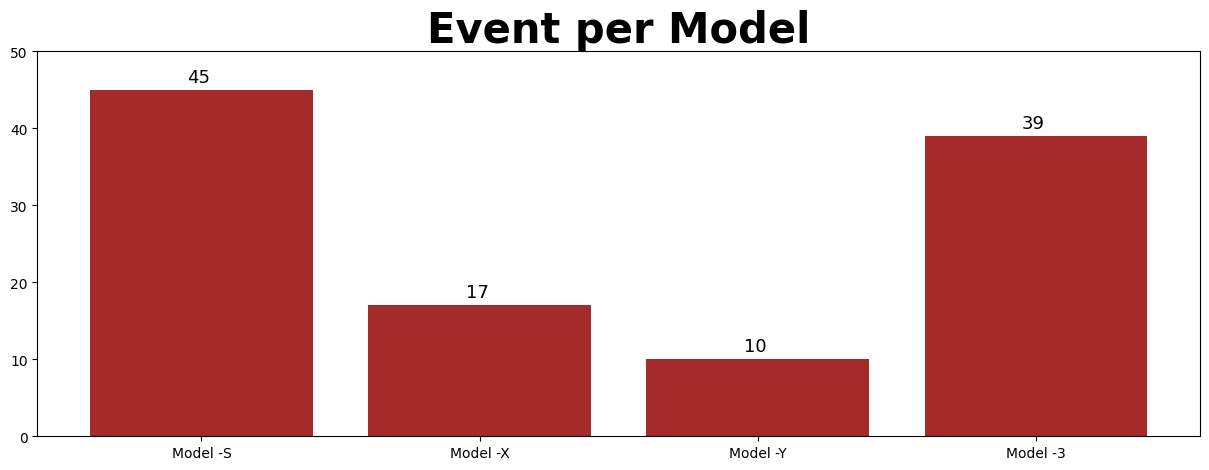

In [45]:
# This is a visually breaks down incident frequency across Tesla’s main models (S, X, Y, and 3), helping identify if certain models are more prone to incidents, which could indicate model-specific vulnerabilities in autopilot or design. By analyzing each model's incident count, you gain insights into whether targeted improvements or software updates may be required for specific models to enhance safety.

# since currently we have only 4 existing models S, X Y and 3 we will analyse them 
vc = data.Model.value_counts()
vc = vc[["S", "X", "Y", "3"]]
plt.figure(figsize = (15,5))
plt.bar(height = vc.values, x = vc.index, color = "brown")
plt.xticks(vc.index, "Model -"+ vc.index.astype(str))
for i in range(len(vc.index)):
  plt.annotate(vc[i], xy = (i-0.05, vc[i]+1), size = 13)
plt.title("Event per Model", size = 30,  weight = "heavy")
plt.ylim(0, 25 * round(vc.max()/25))
plt.show()

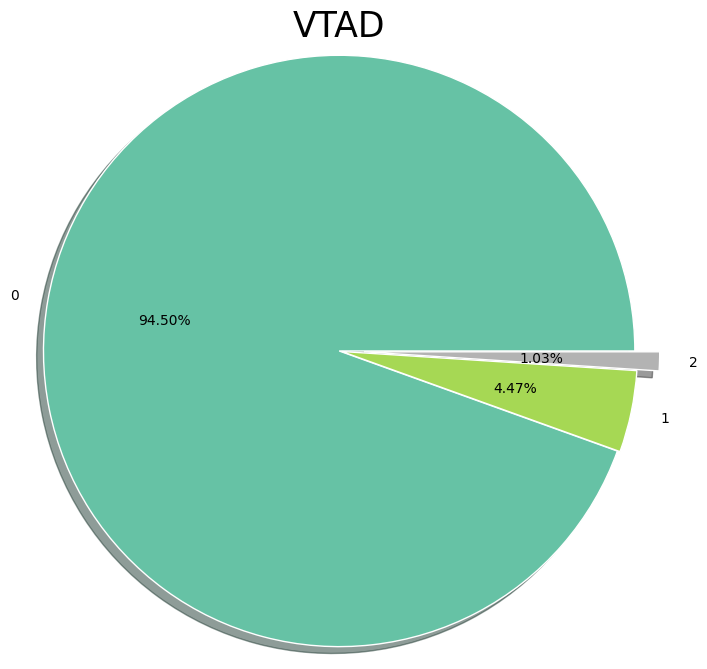

In [46]:
# Visual analyze the distribution of verified Tesla autopilot-related deaths, helping identify the percentage of incidents that involved Tesla’s autopilot at the time of fatality.

# Check the distribution of Verified Tesla autopilot deaths.
vc = data.VTAD.value_counts()
plt.figure(figsize = (10,8))
vc.plot.pie(radius = 1.2, autopct = "%1.2f%%", shadow = True, wedgeprops = {'edgecolor':"white"}, cmap = 'Set2',
            explode = [0.001, 0.01,0.1])
plt.ylabel("")
plt.title("VTAD", pad = 5, size = 25)
plt.show()

In [47]:

# Initial exploration of data after loading
print("Basic Statistics:")
print(data.describe())
print("\nData Information:")
print(data.info())

Basic Statistics:
                                Date      Deaths  Tesla_Driver  \
count                            291  291.000000    291.000000   
mean   2020-07-26 01:19:10.515463936    1.202749      0.395189   
min              2013-04-02 00:00:00    1.000000      0.000000   
25%              2019-08-19 12:00:00    1.000000      0.000000   
50%              2021-03-07 00:00:00    1.000000      0.000000   
75%              2022-04-21 12:00:00    1.000000      1.000000   
max              2022-12-22 00:00:00    4.000000      1.000000   
std                              NaN    0.515410      0.489733   

       Tesla_Occupant  Other_Vehicle  Cyclists_Peds  TSLA_cycl_peds  \
count      291.000000     291.000000     291.000000      291.000000   
mean         0.161512       0.446735       0.158076        0.711340   
min          0.000000       0.000000       0.000000        0.000000   
25%          0.000000       0.000000       0.000000        0.000000   
50%          0.000000       0.00

In [48]:
# Additional EDA
def inspect_columns(data_path):
    import pandas as pd
    data = pd.read_csv(data_path)
    # Display column information to assess relevance
    print(data.info())
    print(data.head())

# Replace 'path_to_your_file.csv' with the actual file path
inspect_columns("Tesla - Deaths.csv")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307 entries, 0 to 306
Data columns (total 24 columns):
 #   Column                                                                Non-Null Count  Dtype  
---  ------                                                                --------------  -----  
 0   Case #                                                                294 non-null    float64
 1   Year                                                                  294 non-null    float64
 2   Date                                                                  294 non-null    object 
 3    Country                                                              294 non-null    object 
 4    State                                                                294 non-null    object 
 5    Description                                                          295 non-null    object 
 6    Deaths                                                               299 non-null    float64
 7  

In [49]:
print(data.columns)

Index(['Date', 'Country', 'State', 'Description', 'Deaths', 'Tesla_Driver',
       'Tesla_Occupant', 'Other_Vehicle', 'Cyclists_Peds', 'TSLA_cycl_peds',
       'Model', 'Claimed', 'VTAD', 'event_year', 'event_month', 'event_day'],
      dtype='object')


In [50]:
# Data Cleaning: Handling missing values, dropping unnecessary columns


data = data.drop(columns=["Note", "Case #"], errors='ignore') 

data.fillna(method='ffill', inplace=True)  

C:\Users\louie\AppData\Local\Temp\ipykernel_1748\2334872217.py:14: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data.fillna(method='ffill', inplace=True)  # Forward-fill as a basic strategy


In [51]:
# Define a plotting function to keep visuals consistent in size and style


def plot_bar(data, x, y, title, xlabel, ylabel):
    plt.figure(figsize=(12,8))
    plt.bar(data[x], data[y], color='skyblue')
    plt.title(title, size=16)
    plt.xlabel(xlabel, size=14)
    plt.ylabel(ylabel, size=14)
    plt.xticks(rotation=45)
    plt.show()

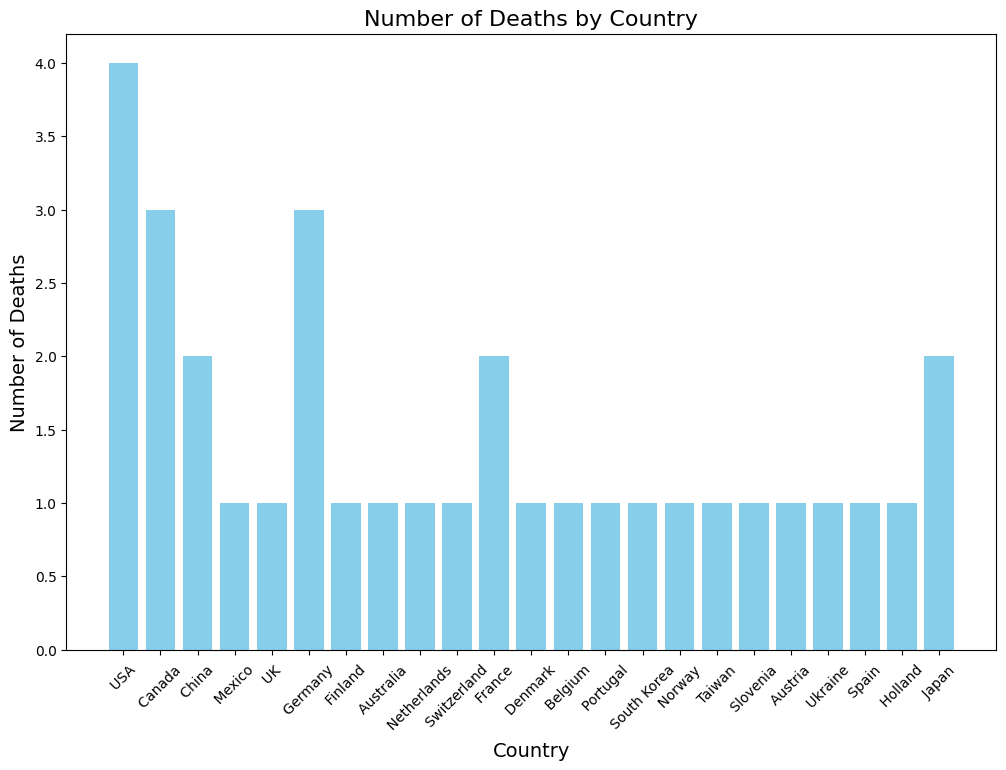

In [52]:
# Accident Involvement Analysis


plot_bar(data, 'Country', 'Deaths', 'Number of Deaths by Country', 'Country', 'Number of Deaths')

### Check the distribution of verified Tesla autopilot deaths

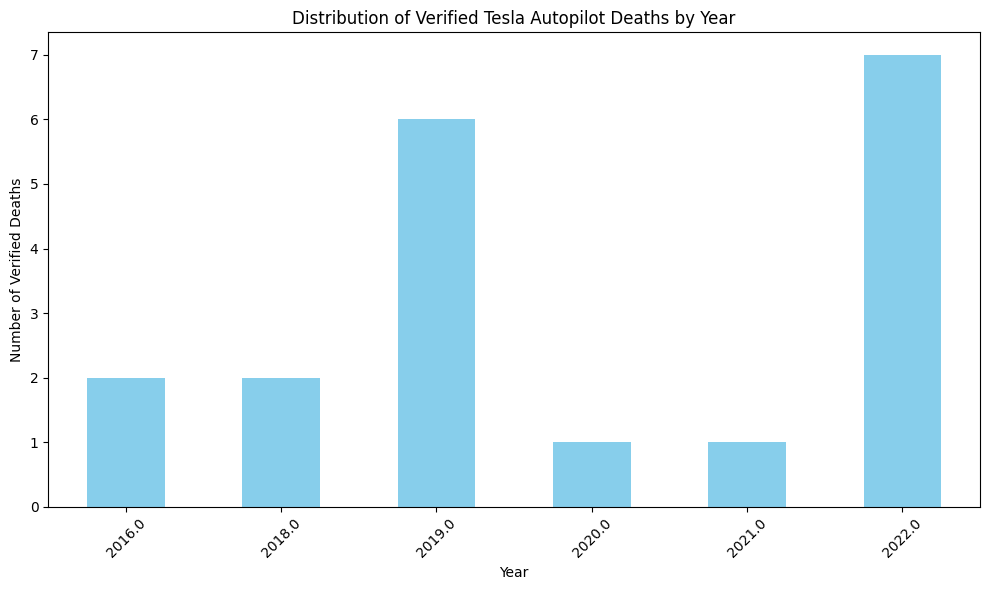

In [3]:
# Check the distribution of verified Tesla autopilot deaths

# Load the dataset (adjust the path as necessary)
tesla_deaths_df = pd.read_csv("Tesla - Deaths.csv")

# Clean the column names by stripping any leading or trailing spaces
tesla_deaths_df.columns = tesla_deaths_df.columns.str.strip()

# Convert the 'Verified Tesla Autopilot Deaths' column to numeric, coercing errors into NaN for non-numeric values
tesla_deaths_df['Verified Tesla Autopilot Deaths'] = pd.to_numeric(tesla_deaths_df['Verified Tesla Autopilot Deaths'], errors='coerce')

# Drop rows where 'Verified Tesla Autopilot Deaths' is NaN
verified_deaths_df = tesla_deaths_df.dropna(subset=['Verified Tesla Autopilot Deaths'])

# Group by year and sum the number of verified deaths for each year
deaths_per_year = verified_deaths_df.groupby('Year')['Verified Tesla Autopilot Deaths'].sum()

# Plot the distribution of verified Tesla Autopilot deaths by year
plt.figure(figsize=(10, 6))
deaths_per_year.plot(kind='bar', color='skyblue')
plt.title('Distribution of Verified Tesla Autopilot Deaths by Year')
plt.xlabel('Year')
plt.ylabel('Number of Verified Deaths')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

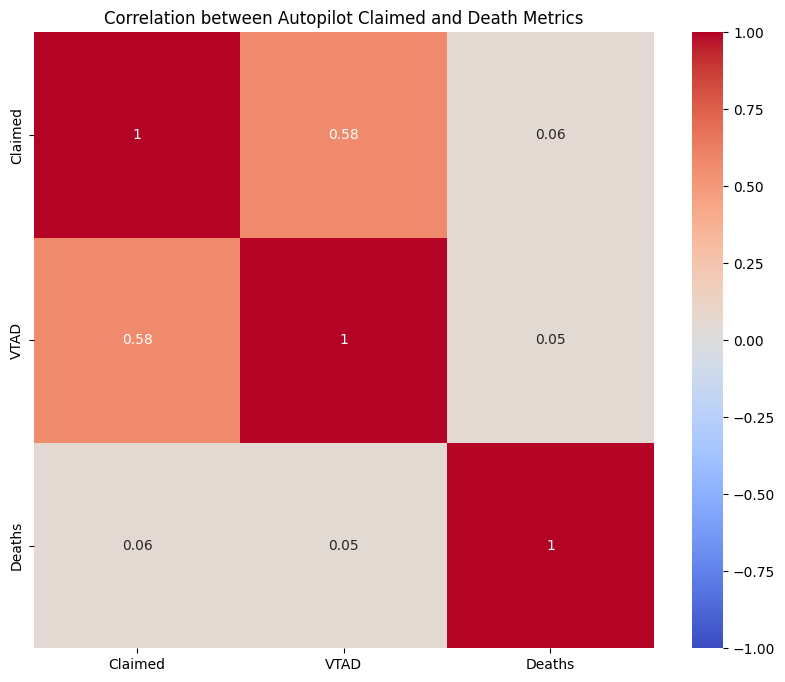

In [53]:
# Identifying relationships between autopilot usage and accident severity

plt.figure(figsize=(10, 8))

# Adjust the column names here to match your actual DataFrame
sns.heatmap(data[['Claimed', 'VTAD', 'Deaths']].corr(), annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation between Autopilot Claimed and Death Metrics')
plt.show()

## Conclusion 

The analysis demonstrates that while Tesla's autopilot system offers promising advancements, specific scenarios—like interactions with cyclists or multi-vehicle collisions—require closer scrutiny. Identifying incident trends by location and time can guide future development to enhance safety in high-risk settings. Furthermore, model-specific incident rates suggest that tailored software updates or feature modifications could optimize autopilot functionality across Tesla’s fleet.

Overall, the analysis serves as a foundation for ongoing monitoring and safety improvement in Tesla’s autopilot technology, emphasizing the importance of adaptive AI and data-driven refinements in real-world autonomous driving applications.